In [1]:
import numpy as np
import pyFDS
import matplotlib.pyplot as plt
import pyExSi as es

# Random Signals Showcase

## SpecificationDevelopment object

Specification development object contains data, required for the calculation of extreme response spectrum (ERS) and fatigue damage spectrum (FDS). It enables calculation for random signals, that are defined with PSD or with time-history.
For time-history, two methods are available. Both spectra can be determined directly from time history using convolution, or by first converting the history into PSD and calculating spectra on the PSD.

This notebook contains showcases for three different random profiles:
- flat shaped PSD
- industry-standard example
- non-stationary signal

For each signal, ERS and FDS are calculated with all three avaiable methods:
- from PSD
- from time-history using convolution
- from time history using PSD averaging

## Random (flat-shaped PSD)

### Generate data

Random signal is generated using PyExSi.

In [2]:
fs = 5000 # sampling frequency [Hz]


time= 500

N = int(time*fs) # number of data points of time signal
t = np.arange(0,N)/fs # time vector

# define frequency vector and one-sided flat-shaped PSD
freq_flat = np.arange(0, fs/2, 1/time) # frequency vector
freq_lower = 200 # PSD lower frequency limit  [Hz]
freq_upper = 1000 # PSD upper frequency limit [Hz]
PSD_flat = es.get_psd(freq_flat, freq_lower, freq_upper,variance=800) # one-sided flat-shaped PSD


#get gaussian stationary signal
gausian_signal = es.random_gaussian(N, PSD_flat, fs)

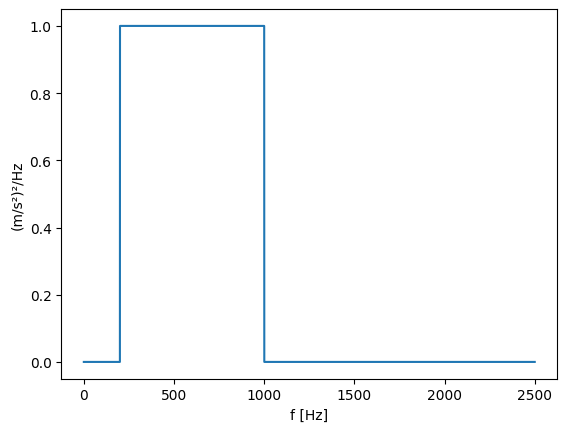

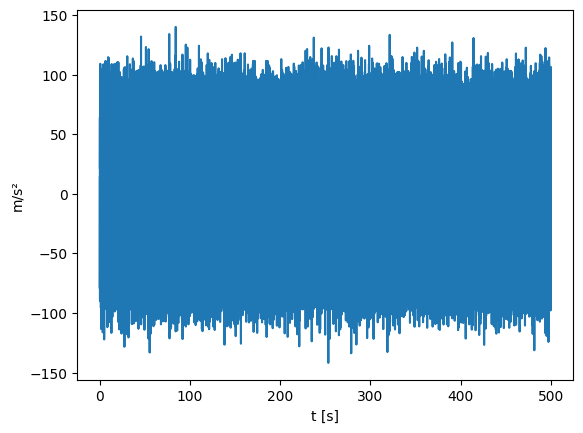

In [3]:
plt.plot(freq_flat, PSD_flat)
plt.xlabel('f [Hz]')
plt.ylabel('(m/s²)²/Hz')
plt.show()

plt.plot(t,gausian_signal)
plt.xlabel('t [s]')
plt.ylabel('m/s²')
plt.show()

### Instantiate Class

Class is instantiated with inputs:
- `freq_data`: tuple containing (f0_start, f0_stop, f0_step) [Hz] or a frequency vector, defining the range where the ERS and FDS will be calculated
-  damping ratio `damp` or damping Q-factor `Q`

In [4]:
sd_flat_psd = pyFDS.SpecificationDevelopment(freq_data=(100,1100,20),damp=0.05)
sd_flat_time = pyFDS.SpecificationDevelopment(freq_data=(100,1100,20),damp=0.05)
sd_flat_time_2 = pyFDS.SpecificationDevelopment(freq_data=(100,1100,20),damp=0.05)

### Set Load

Random load is defined with the `set_random_load` method. Time history or PSD must given as input:
- PSD: input is tuple containing (psd data, frequency vector)
- Time history: input is tuple containing (time history data, dt)

If time history is given as input, method of spectra calculation must also be defined. Available methods are:
- `convolution`
- `psd_averaging`

In [6]:
sd_flat_psd.set_random_load((PSD_flat[::100],freq_flat[::100]),unit='ms2',T=500) #input is tuple (psd array, freq array)
sd_flat_time.set_random_load((gausian_signal,1/fs), unit='ms2',method='convolution') #input is tuple (psd data, frequency vector)
sd_flat_time_2.set_random_load((gausian_signal,1/fs), unit='ms2',method='psd_averaging',bins=500) #input is tuple (psd data, frequency vector)

### Get ERS and FDS

Extreme Response Spectra:

In [7]:
sd_flat_psd.get_ers()
sd_flat_time.get_ers()
sd_flat_time_2.get_ers()

100%|██████████| 51/51 [00:20<00:00,  2.54it/s]


 Fatigue Damage Spectra:

In [8]:
# 'get_fds' method requires material fatigue parameters

b=10
C=1e80
K=6.3*1e10

sd_flat_psd.get_fds(b=b,C=C,K=K)
sd_flat_time.get_fds(b=b,C=C,K=K)
sd_flat_time_2.get_fds(b=b,C=C,K=K)

100%|██████████| 51/51 [01:37<00:00,  1.90s/it]


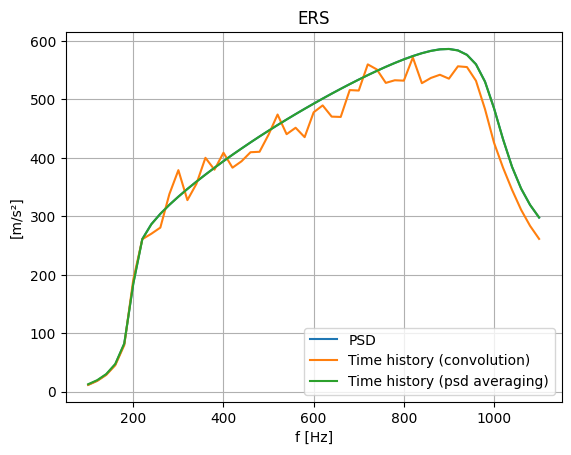

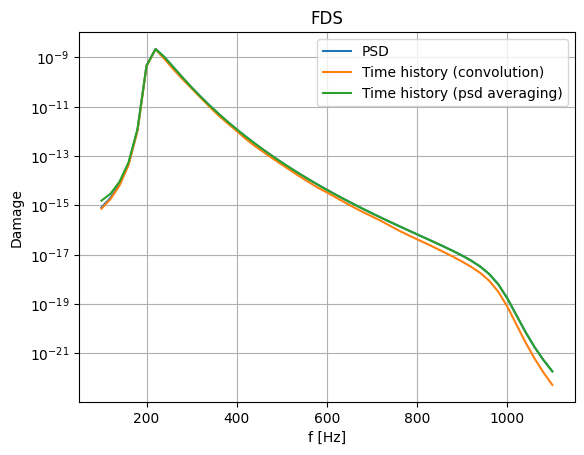

In [13]:
plt.plot(sd_flat_psd.f0_range,sd_flat_psd.ers,label='PSD')
plt.plot(sd_flat_time.f0_range,sd_flat_time.ers,label='Time history (convolution)')
plt.plot(sd_flat_time_2.f0_range,sd_flat_time_2.ers,label='Time history (psd averaging)')
plt.title('ERS')
plt.legend()
plt.grid()
plt.ylabel('[m/s²]')
plt.xlabel('f [Hz]')
plt.show()

plt.semilogy(sd_flat_psd.f0_range,sd_flat_psd.fds,label='PSD')
plt.semilogy(sd_flat_time.f0_range,sd_flat_time.fds,label='Time history (convolution)')
plt.semilogy(sd_flat_time_2.f0_range,sd_flat_time_2.fds,label='Time history (psd averaging)')
plt.title('FDS')
plt.ylabel('Damage')
plt.xlabel('f [Hz]')
plt.grid()
plt.legend()

## Random (Industry standard profile example)

### Import data

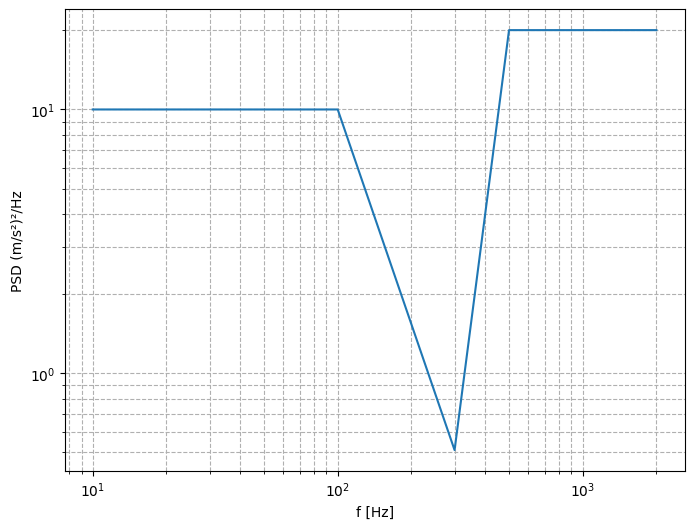

Text(0, 0.5, 'm/s²')

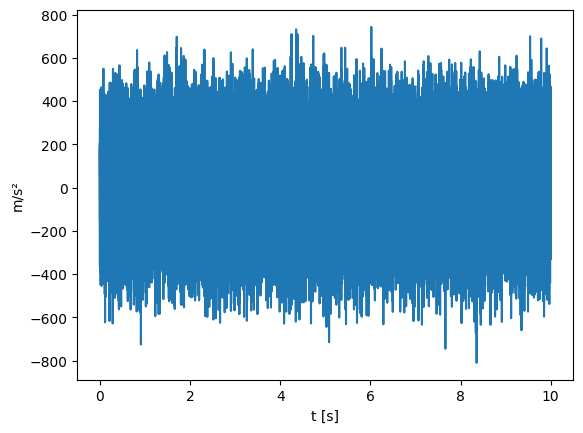

In [16]:
import numpy as np
import matplotlib.pyplot as plt

fs = 10000 # sampling frequency [Hz]

time= 10 # time duration [s]

N = time*fs # number of data points of time signal
t = np.arange(0,N)/fs # time vector

freq_input = np.array([10, 100, 300, 500, 2000])
psd_input = np.array([10, 10, 0.51, 20, 20])

# Create the frequency vector
freq_test = np.arange(freq_input[0], freq_input[-1], 1/time)

# Interpolate in log-log space
log_freq_input = np.log10(freq_input)
log_psd_input = np.log10(psd_input)

log_psd_test = np.interp(np.log10(freq_test), log_freq_input, log_psd_input)
psd_test = 10**log_psd_test

test_time = es.random_gaussian(N, psd_test, fs)

plt.figure(figsize=(8,6))
plt.loglog(freq_test, psd_test)
plt.xlabel("f [Hz]")
plt.ylabel('PSD (m/s²)²/Hz')
plt.grid(True, which="both", ls="--")
plt.show()

plt.plot(t,test_time)
plt.xlabel('t [s]')
plt.ylabel('m/s²')


### Instantiate Class

In [17]:
sd_test = pyFDS.SpecificationDevelopment(freq_data=(10,2000,5))
sd_test_time = pyFDS.SpecificationDevelopment(freq_data=(10,2000,5))
sd_test_time_2 = pyFDS.SpecificationDevelopment(freq_data=(10,2000,5))

### Set Load

In [18]:
sd_test.set_random_load((psd_test,freq_test), unit='ms2',T=10) #input is tuple (psd array, freq array)
sd_test_time.set_random_load((test_time,1/fs), unit='ms2') #input is tuple (psd array, freq array)
sd_test_time_2.set_random_load((test_time,1/fs), unit='ms2',method='psd_averaging',bins=10) #input is tuple (psd array, freq array)


### Get ERS and FDS

In [19]:
sd_test.get_ers()
sd_test_time.get_ers()
sd_test_time_2.get_ers()

100%|██████████| 399/399 [00:04<00:00, 86.07it/s]


In [20]:
sd_test.get_fds(b=5,C=1,K=1)
sd_test_time.get_fds(b=5,C=1,K=1)
sd_test_time_2.get_fds(b=5,C=1,K=1)

100%|██████████| 399/399 [00:20<00:00, 19.10it/s]


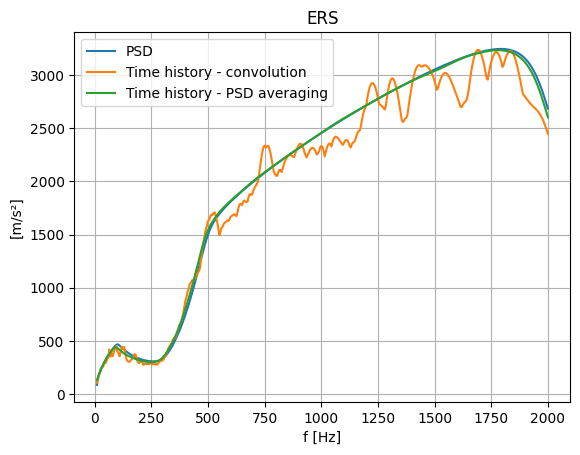

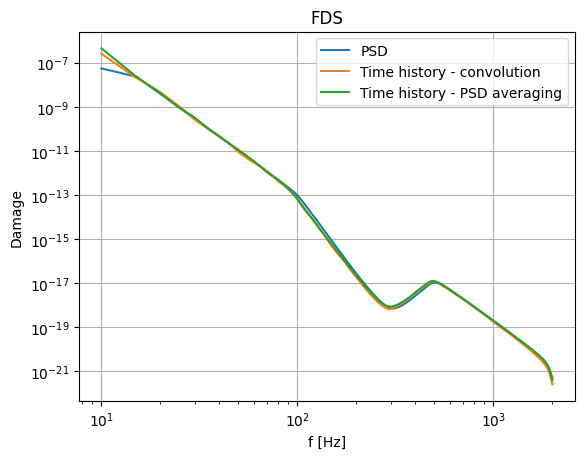

In [21]:
plt.plot(sd_test.f0_range,sd_test.ers,label='PSD')
plt.plot(sd_test_time.f0_range,sd_test_time.ers,label='Time history - convolution')
plt.plot(sd_test_time_2.f0_range,sd_test_time_2.ers,label='Time history - PSD averaging')
plt.title('ERS')
plt.legend()
plt.grid()
plt.ylabel('[m/s²]')
plt.xlabel('f [Hz]')
plt.show()

plt.loglog(sd_test.f0_range,sd_test.fds,label='PSD')
plt.loglog(sd_test_time.f0_range,sd_test_time.fds,label='Time history - convolution')
plt.loglog(sd_test_time_2.f0_range,sd_test_time_2.fds,label='Time history - PSD averaging')
plt.title('FDS')
plt.ylabel('Damage')
plt.xlabel('f [Hz]')
plt.grid()
plt.legend()

## Random (Non stationary)

### Import data

In [22]:
_psd_data = np.load('test_data/test_psd.npy', allow_pickle=True)
psd_freq = _psd_data[:,0]
psd_data = _psd_data[:,1]

_time_data = np.load('test_data/test_time_history.npy', allow_pickle=True)
time_history_data = _time_data[:,1]
t = _time_data[:,0] 
dt = t[2] - t[1]

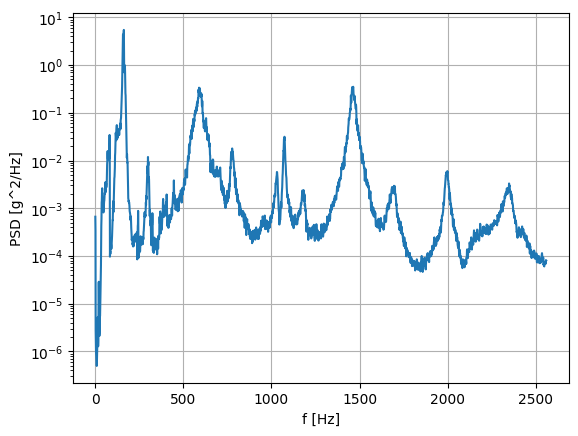

Text(0, 0.5, 'Acceleration [g]')

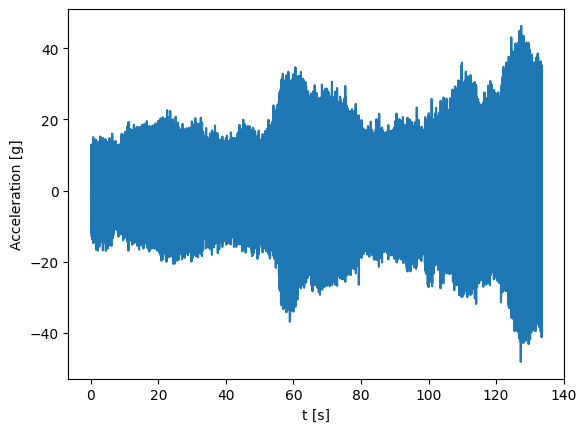

In [23]:
plt.semilogy(psd_freq, psd_data)
plt.xlabel('f [Hz]')
plt.ylabel('PSD [g^2/Hz]')
plt.grid()
plt.show()

plt.plot(t, time_history_data)
plt.xlabel('t [s]')
plt.ylabel('Acceleration [g]')

### Instantiate Class

In [24]:
sd3 = pyFDS.SpecificationDevelopment(freq_data=(20,200,5)) #PSD
sd4 = pyFDS.SpecificationDevelopment(freq_data=(20,200,5)) #time history (convolution)
sd5 = pyFDS.SpecificationDevelopment(freq_data=(20,200,5)) #time history (psd averaging)

### Set Load

In [25]:
sd3.set_random_load((psd_data,psd_freq), unit='g',T=t[-1]) #input is tuple (psd array, freq array)
sd4.set_random_load((time_history_data,dt), unit='g') #(time history, dt)
sd5.set_random_load((time_history_data,dt), unit='g',method='psd_averaging',bins=10) #(time history, dt)

### Get ERS and FDS

In [26]:
sd3.get_ers()
sd4.get_ers()
sd5.get_ers()

100%|██████████| 37/37 [00:04<00:00,  8.20it/s]


In [27]:
sd3.get_fds(b=5,C=1,K=1)
sd4.get_fds(b=5,C=1,K=1)
sd5.get_fds(b=5,C=1,K=1)

100%|██████████| 37/37 [00:10<00:00,  3.49it/s]


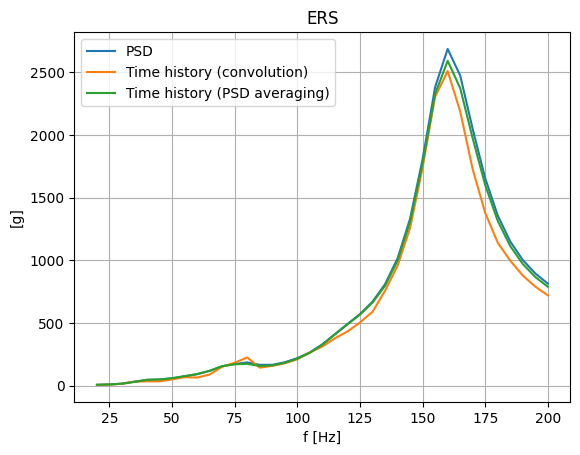

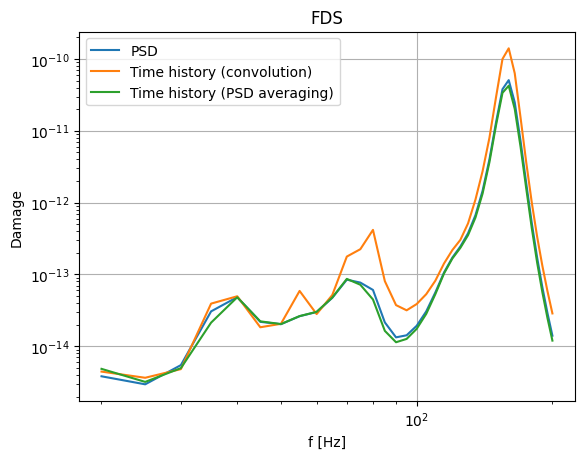

In [28]:
plt.plot(sd3.f0_range,sd3.ers,label='PSD')
plt.plot(sd4.f0_range,sd4.ers,label='Time history (convolution)')
plt.plot(sd5.f0_range,sd5.ers,label='Time history (PSD averaging)')
plt.title('ERS')
plt.legend()
plt.grid()
plt.ylabel('[g]')
plt.xlabel('f [Hz]')
plt.show()


plt.loglog(sd3.f0_range,sd3.fds,label='PSD')
plt.loglog(sd4.f0_range,sd4.fds,label='Time history (convolution)')
plt.loglog(sd5.f0_range,sd5.fds,label='Time history (PSD averaging)')
plt.title('FDS')
plt.ylabel('Damage')
plt.xlabel('f [Hz]')
plt.grid()
plt.legend()

